## **Preprocessamento e Ajustes dos Dados**

#### **IMPORT E LOAD DE DADOS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('ggplot')
# PROCESSAMENTO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# MODELOS
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df_file = "https://raw.githubusercontent.com/ddlandim/monografy-ann-demand-prediction/master/experimentos_monografia/input/Todos.csv"

df = pd.read_csv(df_file,index_col='DATA',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514 entries, 2017-12-04 to 2019-12-16
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEMESTRE_1               514 non-null    int64  
 1   SEMESTRE_2               514 non-null    int64  
 2   SEGUNDA                  514 non-null    int64  
 3   TERCA                    514 non-null    int64  
 4   QUARTA                   514 non-null    int64  
 5   QUINTA                   514 non-null    int64  
 6   SEXTA                    514 non-null    int64  
 7   DISTANCIA_DIA_ANTERIOR   514 non-null    int64  
 8   DISTANCIA_DIA_POSTERIOR  514 non-null    int64  
 9   PERC_CONCLUSAO_SEM       514 non-null    float64
 10  PERC_CONCLUSAO_MES       514 non-null    float64
 11  PRESSAO_ATMOSFERICA      514 non-null    float64
 12  TEMPERATURA              514 non-null    float64
 13  UMIDADE                  514 non-null    int64  
 14  VENTO  

In [ ]:
print(df.columns)

Index(['SEMESTRE_1', 'SEMESTRE_2', 'SEGUNDA', 'TERCA', 'QUARTA', 'QUINTA',
       'SEXTA', 'DISTANCIA_DIA_ANTERIOR', 'DISTANCIA_DIA_POSTERIOR',
       'PERC_CONCLUSAO_SEM', 'PERC_CONCLUSAO_MES', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA', 'UMIDADE', 'VENTO', 'VENDAS_ALMOCO', 'VENDAS_ALMOCO_1',
       'VENDAS_ALMOCO_2', 'VENDAS_ALMOCO_3', 'VENDAS_ALMOCO_4',
       'VENDAS_ALMOCO_5', 'ENTR_ALMOCO', 'ENTR_ALMOCO_1', 'ENTR_ALMOCO_2',
       'ENTR_ALMOCO_3', 'ENTR_ALMOCO_4', 'ENTR_ALMOCO_5', 'ENTR_JANTAR',
       'ENTR_JANTAR_1', 'ENTR_JANTAR_2', 'ENTR_JANTAR_3', 'ENTR_JANTAR_4',
       'ENTR_JANTAR_5'],
      dtype='object')


In [ ]:
df['ENTR_ALMOCO_1'][50] == df['ENTR_ALMOCO_2'][51]

True

#### **FUNÇÕES AUXILIARES**

In [ ]:
# plota serie
def plot_serie(serie, size=(12,4), title='Plot'):
    plt.figure(figsize=size)
    plt.title(title)
    plt.plot(serie)
    plt.show()

In [ ]:
# pega coluna dataframe['coluna_y'] e usa como y
# todas as outras colunas usa como x 
def to_supervised_numpy(dataframe, coluna_y):
    X = dataframe.loc[:, dataframe.columns != coluna_y].values # instantes de tempo passado (lags)
    Y = dataframe[coluna_y].values # valor atual para prever
    return np.array(X), np.array(Y)


In [ ]:
def plot_history(history, start_epoch=0):
    start_epoch = 10
    plt.figure(figsize=(10,4))
    plt.title('História Treino')
    plt.plot(history.history['loss'][start_epoch:], label='Train Loss')
    plt.plot(history.history['val_loss'][start_epoch:], label='Validation Loss')
    plt.legend()

In [ ]:
df_models_metrics = pd.DataFrame()
df_models_metrics['parameters'] =  ['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']

df_models_metrics2 = pd.DataFrame()
df_models_metrics2['parameters'] =  ['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']

In [ ]:
def pe (row,true,predicted): # array of % error
    true = row[true]
    predicted = int(row[predicted])
    error = predicted - true
    if true == 0:
        pe = 0
    else:
        pe = abs(error/true)
    return pe,error

def mape (_df,x,y): # mean of array of % error
    df = pd.DataFrame()
    df = _df
    arr_pe = [0,0]
    arr_pe = df.apply(lambda row: pe(row,x,y), axis=1)
    return np.mean(arr_pe[0])*100 , arr_pe[1]

def avaliacao_predicoes (_df,true,pred,df_models_metrics):
    df = pd.DataFrame()
    df = _df
    arr_true = df[true]
    arr_pred = df[pred]
    m_r, m_p = scipy.stats.pearsonr(arr_true, arr_pred)
    print("CORRELAÇÃO (r): " + str(m_r) + " Pi (p) :" + str(m_p))
    sns.regplot(x=arr_true,y=arr_pred,data=df)
    rmse = mean_squared_error(arr_true, arr_pred, squared=False)
    print("RMSE = " + str(rmse))
    arr_e = []
    arr_pe = []
    #m_mape,arr_e = mape(df,true,pred)
    for true_i,pred_i in zip(arr_true,arr_pred):
        arr_e += [pred_i - true_i]
        if true_i == 0:
            arr_pe += [0]
        else:
            arr_pe += [(pred_i - true_i)/true_i]
    m_mae = np.mean(np.abs(arr_e))
    m_mape = np.mean(np.abs(arr_pe))*100
    subpredictions = sum(i for i in arr_e if i < 0)
    superpredictions = sum(i for i in arr_e if i >= 0)
    print("TOTAL DE REFEIÇÕES PROJETADAS = " + str(len(arr_pred)) + " : " + str(sum(arr_pred)))
    print("TOTAL DE REFEIÇÕES CONSUMIDAS = " + str(len(arr_true)) + " : " + str(sum(arr_true)))
    print("TOTAL DE REFEIÇÕES SUB PROJETADAS = " + str(subpredictions))
    print("TOTAL DE REFEIÇÕES SUPER PROJETADAS = " + str(superpredictions))
    print("ERRO ABSOLUTO MÉDIO = " + str(m_mae))
    print("ERRO ABSOLUTO PERCENTUAL MÉDIO = " + str(m_mape)+"%")
    plt.figure(figsize=(30,5))
    df[true].plot( linewidth=1.5, color='red', label = true)
    df[pred].plot( linewidth=2.5, color='blue', label = pred)
    plt.legend()
    plt.xlabel("Index", labelpad=15)
    plt.show()
    #['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']
    #df_models_metrics.drop(columns=[pred])
    df_models_metrics[pred] = [sum(arr_pred),sum(arr_true),subpredictions,superpredictions,m_mae,m_mape]
    return m_r,m_p,rmse,m_mape,subpredictions,superpredictions
    
def ru_pred_almoco (row,factor):
    true_5days_ago = row['ENTR_ALMOCO_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

def ru_pred_jantar (row,factor):
    true_5days_ago = row['ENTR_JANTAR_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

#### **SPLIT TREINO / TESTE**

In [ ]:
# parametros divisao
validation_start = '2018-02-26' # primeiro dia 2018
test_start = '2019-02-20' # primeiro dia 2019
validation_semester = 'SEMESTRE_1'
# divide df completo
df_train = df[:validation_start]
df_val = df[validation_start:test_start]
df_test = df[test_start:]

print('Treino: {}'.format(len(df_train)))
print('Validação: {}'.format(len(df_val)))
print('Teste: {}'.format(len(df_test)))

Treino: 157
Validação: 188
Teste: 182


#### **FORMATANDO FEATURES TEMPORAIS PARA SHAPE COMPATÍVEL COM REDES RECORRENTES**
shape = (num_samples,   num_lags_passados,   num_features)

In [ ]:
# pegando features temporais
# IMPORTANTE ESTAR EM ORDEM !! PRIMEIRO ELEMENTO = Y E OS DEMAIS = X0, X1, ...
feature_0 = ['ENTR_ALMOCO', 'ENTR_ALMOCO_1', 'ENTR_ALMOCO_2','ENTR_ALMOCO_3', 'ENTR_ALMOCO_4', 'ENTR_ALMOCO_5',]
feature_1 = ['VENDAS_ALMOCO','VENDAS_ALMOCO_1','VENDAS_ALMOCO_2','VENDAS_ALMOCO_3','VENDAS_ALMOCO_4','VENDAS_ALMOCO_5']
feature_2 = ['ENTR_JANTAR','ENTR_JANTAR_1', 'ENTR_JANTAR_2', 'ENTR_JANTAR_3', 'ENTR_JANTAR_4','ENTR_JANTAR_5']
features_temporais = [feature_0, feature_1, feature_2]
##################################################
feature_to_predict = 0 # ENTR_ALMOCO, feature 0 que será o valor da saída do modelo (trocar se quiser)
##################################################
num_temporais = len(features_temporais) # 3 séries temporais


train_x, train_y = [], []
val_x, val_y = [], []
test_x, test_y = [], []
# serapando em dfs com somente uma feature
for feature_cols in features_temporais:
    # train
    x, y = to_supervised_numpy(df_train[feature_cols], feature_cols[0]) # feature[0] = ENTR_ALMOCO = y!!! IMPORTANTE  
    train_x.append(x); train_y.append(y)
    # validacao
    x, y = to_supervised_numpy(df_val[feature_cols], feature_cols[0]) # feature[0] = VENDAS_ALMOCO = y!!! IMPORTANTE  
    val_x.append(x); val_y.append(y)
    # test
    x, y = to_supervised_numpy(df_test[feature_cols], feature_cols[0]) # feature[0] = ENTR_JANTAR = y !!! IMPORTANTE  
    test_x.append(x); test_y.append(y)

    
# transforma em numpy array
train_x = np.array(train_x);  train_y = np.array(train_y); 
val_x = np.array(val_x);  val_y = np.array(val_y); 
test_x = np.array(test_x);  test_y = np.array(test_y); 
#
print('shape treino:', val_x.shape, val_y.shape)
print('shape validacao:', train_x.shape, train_y.shape)
print('shape teste:', test_x.shape, test_y.shape)

shape treino: (3, 188, 5) (3, 188)
shape validacao: (3, 157, 5) (3, 157)
shape teste: (3, 182, 5) (3, 182)


#### **TRATAMENTO DE OUTLIERS NAS FEATURES TEMPORAIS**
verifica se é distante da média

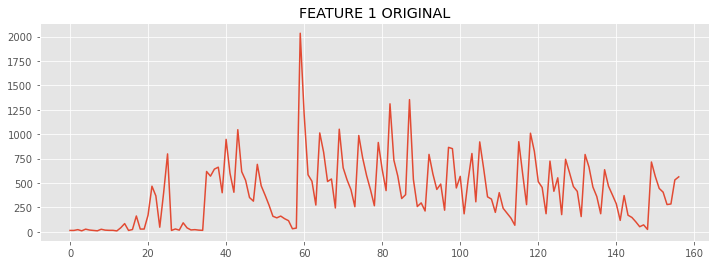

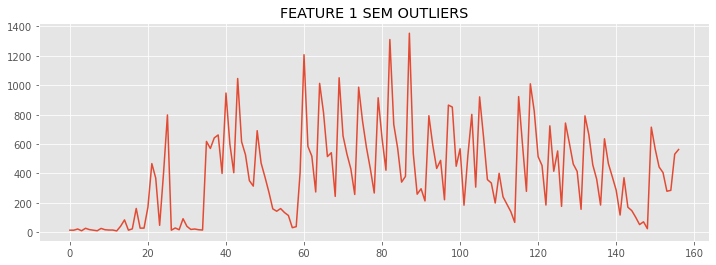

5 outliers  aredondados para a media


In [ ]:
TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS = True
tolerancia_sigma = 3
num_outliers = 0
if TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS:
    plot_serie(train_x[1, :, 0], title='FEATURE 1 ORIGINAL')
    num_outliers = 0
    for feature_i in range(num_temporais):
        desvio_padrao = np.std(train_x[feature_i, :, 0])
        media = np.mean(train_x[feature_i, :, 0])
        for lag_i in range(train_x.shape[2]):
            for element_i in range(train_x.shape[1]):
                valor = train_x[feature_i, element_i, lag_i]
                if np.abs(valor - media) >= tolerancia_sigma*desvio_padrao:
                    train_x[feature_i, element_i, lag_i] = media
                    num_outliers += 1
    
    plot_serie(train_x[1, :, 0], title='FEATURE 1 SEM OUTLIERS')
    print(num_outliers, 'outliers  aredondados para a media')

#### **ESCALONANDO FEATURES TEMPORAIS (MINMAX SCALER)**

Criados 3 scalers para as features temporais
(3, 5, 157, 1) (3, 157, 1)
(3, 5, 188, 1) (3, 188, 1)
(3, 5, 182, 1) (3, 182, 1)


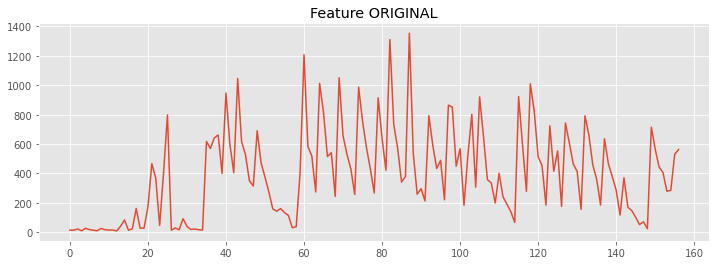

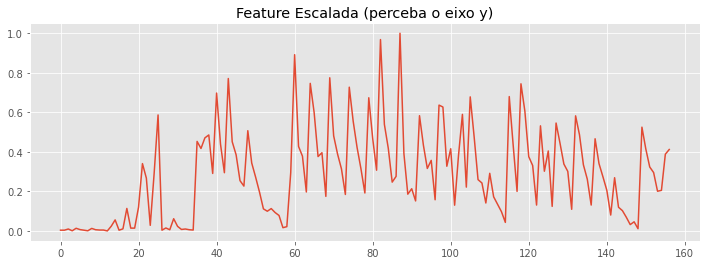

In [ ]:
#
# o correto seria escalonar antes de dividir em lags mas como ja foi dividido sera preciso
# fazer dessa forma não muito otimizada
# escalando features
scalers = [MinMaxScaler([0,1]) for i in range(num_temporais)] # Um scaler para cada feature TEMPORAL
print('Criados', len(scalers),'scalers para as features temporais')

# nao é a maneira mais eficiente, mas é a mais facil de implementar nessas condicoes

def treina_scalers(train_x):
    for i in range(len(train_x)): # pra cada feature
        feature_x = train_x[i]
        scalers[i].fit(feature_x[:, 0].reshape(-1,1)) # poderia usar qualquer coluna(lag), usando a primeira aqui
#     
def scala_features(data_x, data_y):
    scaled_data_x, scaled_data_y = [], []
    for feature_i in range(len(data_x)): # pra cada feature
        x = data_x[feature_i]; y = data_y[feature_i].reshape(-1, 1)
        scaled_x = []
        # pra cada lag, aplicar transform depois de ter 'treinado' o scaler(calculado parametros media etc)
        for lag in range(x.shape[1]): # x.shape[1] = numero de lags (nesse caso 5)
            lag_scaled = scalers[feature_i].transform(x[:, lag].reshape(-1,1)) # lag atual, ENTR_JANTAR_'lag' por exemplo
            scaled_x.append(lag_scaled) # adiciona cada lag no vetor de retorno, lag_1, lag_2 .. lag_5
        # scaled_x = vetor de lags para a feature do for mais externo, feature de indice feature_i
        scaled_data_x.append(np.array(scaled_x))
        scaled_data_y.append(scalers[feature_i].transform(y))
    return np.array(scaled_data_x), np.array(scaled_data_y)


# treina
treina_scalers(train_x) # treina os scalers para depois usar
# fit transform
scaled_train_x, scaled_train_y = scala_features(train_x, train_y)
scaled_val_x, scaled_val_y = scala_features(val_x, val_y)
scaled_test_x, scaled_test_y = scala_features(test_x, test_y)


# (num_features, num_lags, num_samples, 1) e (num_features, num_samples, 1)
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)

#
feature_para_ver = 1
plot_serie(train_x[feature_para_ver, :, 0], title='Feature ORIGINAL')
plot_serie(scaled_train_x[feature_para_ver, 0, :, 0], title='Feature Escalada (perceba o eixo y)')


#### **TRANSPONDO MATRIZES (SÓ UMA CONVENÇÃO, NÃO ALTERA NADA)**
Transpõe matrizes para ordem correta dos eixos
* Shape de Antes: **data_X:(num_features, num_lags, num_instancias, 1) data_Y:(num_features, num_instancias, 1)**
* Shape de Depois: **data_X:(num_instancias, num_lags, num_features) data_Y:(num_instancias, num_features)**

In [ ]:
def transpose_to_rnn(data_x, data_y): # faz a transposição (necessario devido ao problema citado acima)
    data_x = data_x.transpose(2, 1, 0, 3)
    data_y = data_y.transpose(1, 0, 2)
    data_x = np.squeeze(data_x) # remove ultima dimensão desnecessaria()
    data_y = np.squeeze(data_y) # remove ultima dimensão desnecessaria()

    return data_x, data_y
# sobreescreve matrizes , portanto executar uma única vez
scaled_train_x, scaled_train_y = transpose_to_rnn(scaled_train_x, scaled_train_y)
scaled_val_x, scaled_val_y = transpose_to_rnn(scaled_val_x, scaled_val_y)
scaled_test_x, scaled_test_y = transpose_to_rnn(scaled_test_x, scaled_test_y)
#
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)
#

(157, 5, 3) (157, 3)
(188, 5, 3) (188, 3)
(182, 5, 3) (182, 3)


#### **REMOVENDO Y QUE NÃO QUEREMOS PREVER DAS FEATURES TEMPORAIS(JANTA POR EXEMPLO)**


In [ ]:
# os vetores train_y, val_y e test_y possuem o y para todas as features
# porém queremos prever somente uma delas (saida da rede pode ser as tres caso quisermos)
# portanto vamos retirar as outras dos vetores y

# dados originais
train_y = train_y[feature_to_predict,:]
val_y = val_y[feature_to_predict,:]
test_y = test_y[feature_to_predict,:]
# dados escalados
scaled_train_y = scaled_train_y[:, feature_to_predict]
scaled_val_y = scaled_val_y[:, feature_to_predict]
scaled_test_y = scaled_test_y[:, feature_to_predict]
print(scaled_train_y.shape)
print(scaled_val_y.shape)
print(scaled_test_y.shape)

(157,)
(188,)
(182,)


#### **SEPARA FEATURES NÃO TEMPORAIS (ONE HOT E NUMERICAS)**


In [ ]:
# features one hot
features_categoricas = ['SEMESTRE_1', 'SEMESTRE_2']
# divide df completo
train_x_cat = df_train[features_categoricas].values
val_x_cat = df_val[features_categoricas].values
test_x_cat = df_test[features_categoricas].values
print('features categoricas one_hot: ',train_x_cat.shape, val_x_cat.shape, test_x_cat.shape)




#features numericas pontuais
features_numericas_pontuais = ['DISTANCIA_DIA_ANTERIOR', 'DISTANCIA_DIA_POSTERIOR',
       'PERC_CONCLUSAO_SEM', 'PERC_CONCLUSAO_MES', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA', 'UMIDADE', 'VENTO']
# divide df completo
train_x_numpont = df_train[features_numericas_pontuais].values
val_x_numpont = df_val[features_numericas_pontuais].values
test_x_numpont = df_test[features_numericas_pontuais].values
print('features numericas pontuais:', train_x_numpont.shape, val_x_numpont.shape, test_x_numpont.shape)

features categoricas one_hot:  (157, 2) (188, 2) (182, 2)
features numericas pontuais: (157, 8) (188, 8) (182, 8)


#### **ESCALA FEATURES NÃO TEMPORAIS E COMPACTA EM UM UNICO VETOR**


In [ ]:
# scaler das features numericas não temporais (temperatura, umidade etc) 
# nesse caso pode usar um unico scaler (ele cria diferentes estatisticas para cada feature)
scaler_numpont = MinMaxScaler([0,1]).fit(train_x_numpont)
train_x_numpont = scaler_numpont.transform(train_x_numpont)
val_x_numpont = scaler_numpont.transform(val_x_numpont)
test_x_numpont = scaler_numpont.transform(test_x_numpont)

# concatena tudo pra alimentar parte densa do modelo
train_x_dense = np.hstack([train_x_numpont, train_x_cat])
val_x_dense = np.hstack([val_x_numpont, val_x_cat])
test_x_dense = np.hstack([test_x_numpont, test_x_cat])

print('treino', train_x_dense.shape)
print('validacao', val_x_dense.shape)
print('teste', test_x_dense.shape)

treino (157, 10)
validacao (188, 10)
teste (182, 10)


In [ ]:
# RESULTADO 
print(scaled_train_x.shape, ' e ', train_x_dense.shape)

(157, 5, 3)  e  (157, 10)


# **Definição e Treino de Modelos**

## TODO: EXPLORANDO O PROBLEMA (RODAR PRIMEIROS TREINOS)
 CRIAR UMA MLP PADRÃO (1 CAMADA 1 SAÍDA), CHEGANDO NELA TODAS AS FEATURES ESCALADAS
 DEIXA-LA PREPARADA PARA SER USADA PARA PREVISÕES ASSIM COMO AS OUTRAS
 ESTA MLP SERÁ USADA PARA EXPLORAR O DOMÍNIO DO PROBLEMA E REALIZAR PRIMEIROS TREINOS. 
 O MAIS IMPORTANTE AQUI É TER O DATASET CHEGANDO INTEIRO E ESCALADO.

In [ ]:
## INSIRA A MLP AQUI.

## **Modelos que usam somente dados endógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_output = 1 # saída é um unico numero escalar
learning_rate = 0.001 # bom valor

### model_rnn_unique_1

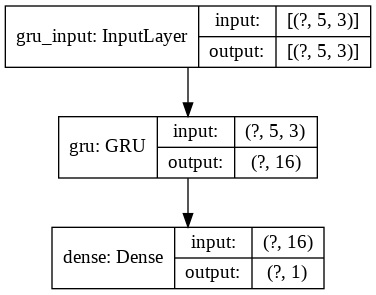

In [ ]:
#model_rnn_unique_1
###################### modelo RNN com uma única camada 
model_rnn_unique_1 = keras.Sequential()
num_units = 16 # ajustavel
model_rnn_unique_1.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
model_rnn_unique_1.add(layers.Dense(num_output, activation='linear'))
model_rnn_unique_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_rnn_unique_1, show_shapes=True)
######################

### model_rnn_unique_2

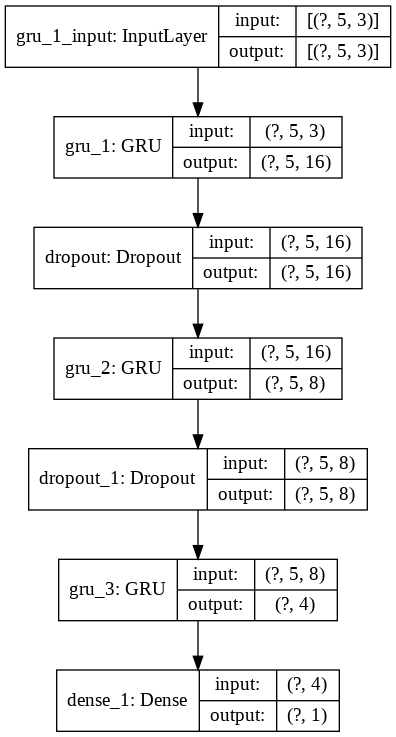

In [ ]:
#model_rnn_unique_2
###################### modelo RNN com mais de uma camada
model_rnn_unique_2 = keras.Sequential()
num_units = 16 # ajustavel
num_units_2 = 8 # ajustavel
num_units_3 = 4 # ajustavel
model_rnn_unique_2.add(layers.GRU(num_units, input_shape=(num_lags, num_features), return_sequences=True)) # return_sequences=True
model_rnn_unique_2.add(layers.Dropout(0.2)) # não necessário porém é bom
model_rnn_unique_2.add(layers.GRU(num_units_2, return_sequences=True))
model_rnn_unique_2.add(layers.Dropout(0.2)) # não necessário porém é bom
model_rnn_unique_2.add(layers.GRU(num_units_3, return_sequences=False)) # return_sequences=False
model_rnn_unique_2.add(layers.Dense(num_output, activation='linear'))


model_rnn_unique_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_rnn_unique_2, show_shapes=True)
###################### 

### model_mlp_unique_1

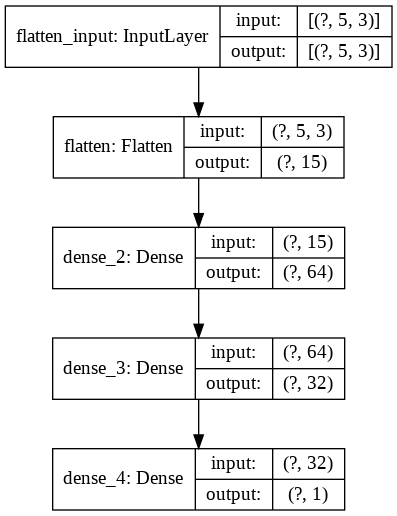

In [ ]:
#model_mlp_unique_1
###################### modelo MLP com uma única camada
model_mlp_unique_1 = keras.Sequential()
model_mlp_unique_1.add(layers.Flatten(input_shape=(num_lags, num_features),))
model_mlp_unique_1.add(layers.Dense(64, activation='relu'))
model_mlp_unique_1.add(layers.Dense(32, activation='relu'))
model_mlp_unique_1.add(layers.Dense(num_output, activation='linear'))
model_mlp_unique_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_mlp_unique_1, show_shapes=True)
######################

###TREINO DOS MODELOS

###model_rnn_unique_1

(157, 5, 3) (157,)


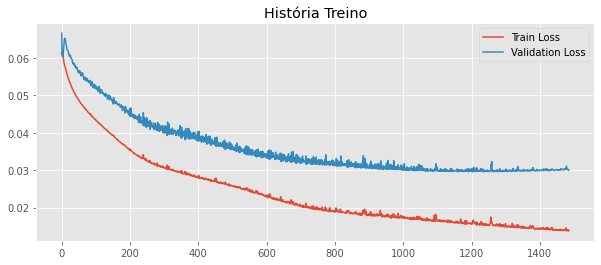

In [ ]:
#model_rnn_unique_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_rnn_unique_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

###model_rnn_unique_2

(157, 5, 3) (157,)


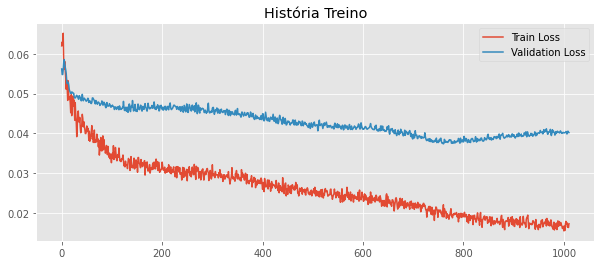

In [ ]:
#################################################################################
#################################################################################
#model_rnn_unique_2
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_rnn_unique_2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

###model_mlp_unique_1

(157, 5, 3) (157,)


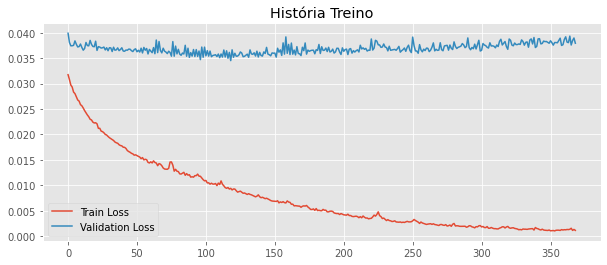

In [ ]:
#################################################################################
#################################################################################
#model_mlp_unique_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_mlp_unique_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

### **AVALIAÇÂO DO MODELO**

###model_rnn_unique_1

RMSE:  88.35000676203033


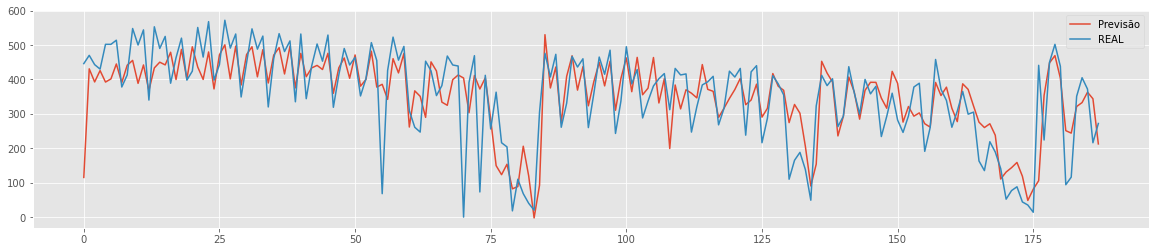

In [ ]:
#model_rnn_unique_1
pred_y = model_rnn_unique_1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

###model_rnn_unique_2

RMSE:  99.38150775132897


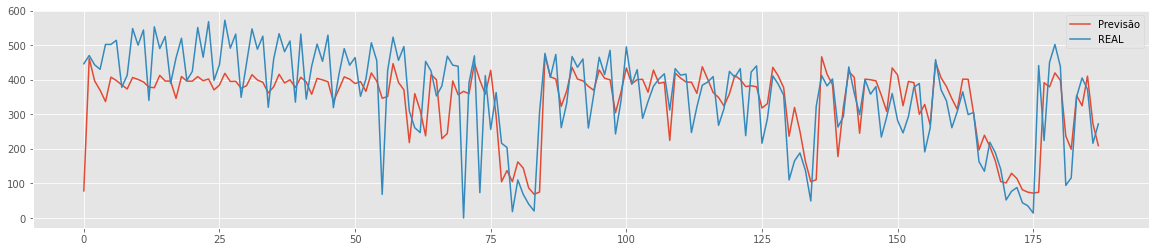

In [ ]:
#model_rnn_unique_2
pred_y = model_rnn_unique_2.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

###model_mlp_unique_1

RMSE:  95.5009554853949


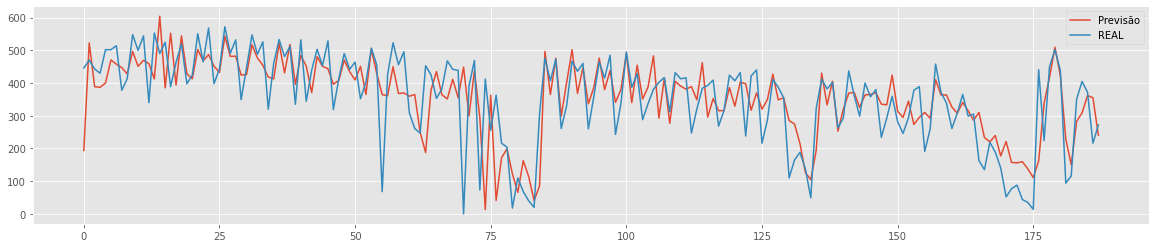

In [ ]:
#model_mlp_unique_1
pred_y = model_mlp_unique_1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

In [ ]:
#model.save('gru_32neur_semrelu.h5')

* **MSE Validação GRU 16 neuronios COM relu:** 9483., 9531., 7857.
* **MSE Validação GRU 16 neuronios SEM relu:** 7496., 7710., 8285.
* **MSE Validação GRU 32 neuronios com relu:** 7463., 7915., 8021.
* **MSE Validação GRU 32 neuronios SEM relu:** 7888., 7442., 8152.

## **Modelos que usam dados endógenos e exógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_dense_features = train_x_dense.shape[1]
num_output = 1
print('Numero de valores totais na entrada da rede:', num_lags * num_features + num_dense_features)

Numero de valores totais na entrada da rede: 25


#### **MULTIINPUT_MODEL_1 RNN e DENSO (multinput) - UMA CAMADA RNN E UMA DENSA**

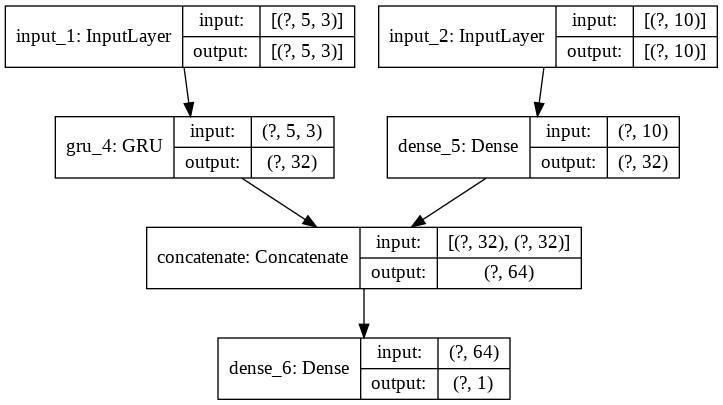

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru, layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_1 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################



multiinput_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_1, show_shapes=True)


#### **MULTIINPUT_MODEL_2 MODELO RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (SEM DROPOUT)**

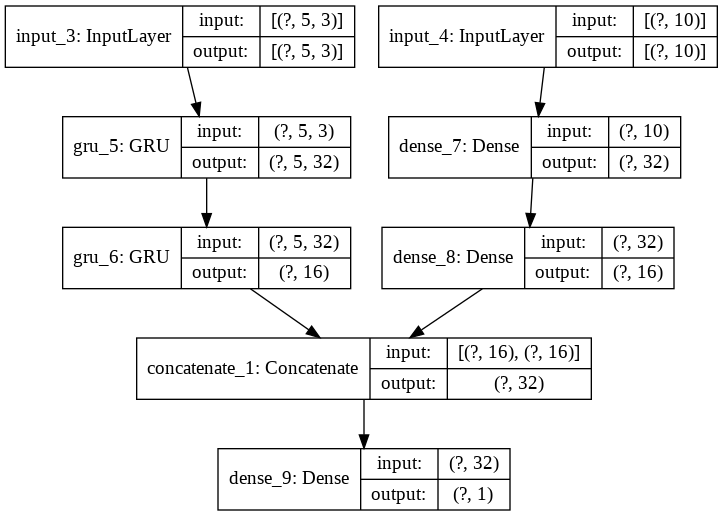

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=True)(input_layer_recorrente)

layer_gru_2 = layers.GRU(16, )(layer_gru)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_2 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################



multiinput_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_2, show_shapes=True)


#### **MULTIINPUT_MODEL_3 RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (COM DROPOUT)**


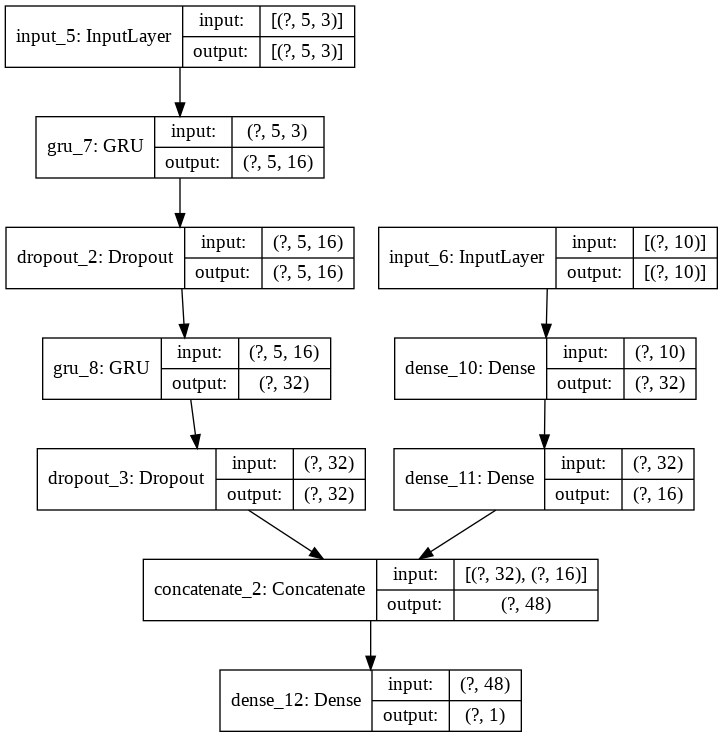

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(16, return_sequences=True)(input_layer_recorrente)
layer_dropout = layers.Dropout(0.2)(layer_gru)
layer_gru_2 = layers.GRU(32,)(layer_dropout)
layer_dropout_2 = layers.Dropout(0.2)(layer_gru_2)

# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_dropout_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_3 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################



multiinput_model_3.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_3, show_shapes=True)


#### **TREINOS MODELOS MULTINPUT**

#### **multiinput_model_1**

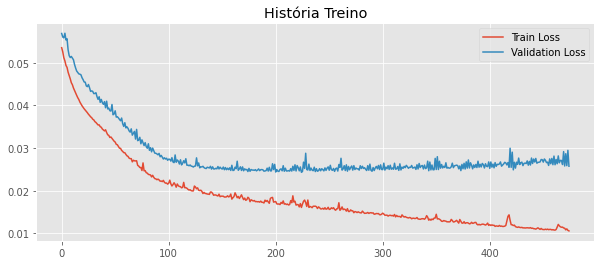

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_1.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **multiinput_model_2**

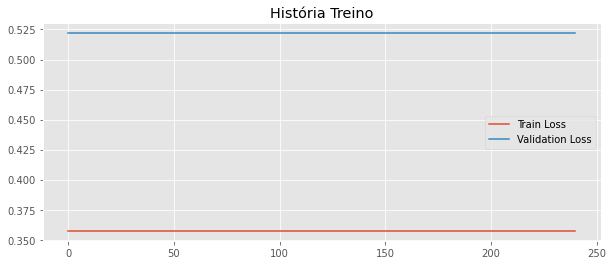

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_2.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **multiinput_model_3**

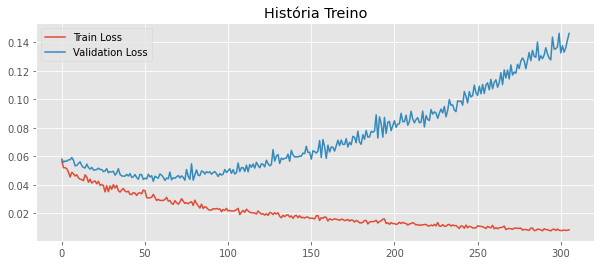

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_3.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **AVALIAÇÂO DO MODELO**

#### **multiinput_model_1**

RMSE:  80.16458837903274


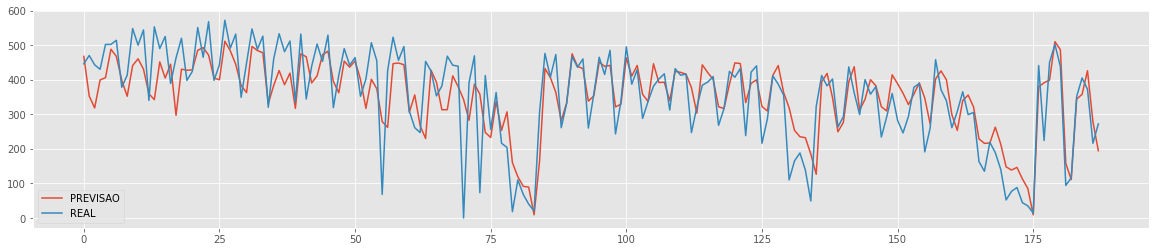

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y = multiinput_model_1.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='PREVISAO')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **multiinput_model_2**

RMSE:  371.3207926717554


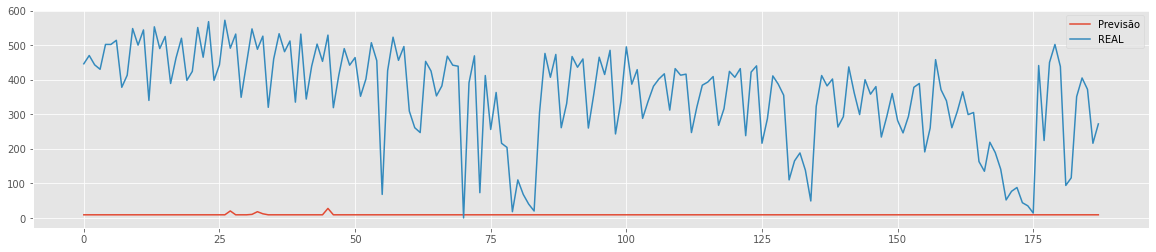

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y = multiinput_model_2.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **multiinput_model_3**

RMSE:  105.92035006614351


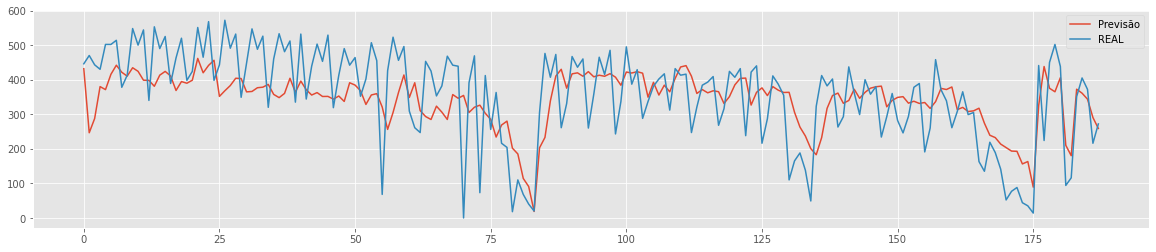

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y = multiinput_model_3.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

# **TESTE - FINAL**

#### **MODELOS SÓ COM FEATURES TEMPORAIS**
model_rnn_unique_1
model_rnn_unique_2
model_mlp_unique_2

#### **model_rnn_unique_1**

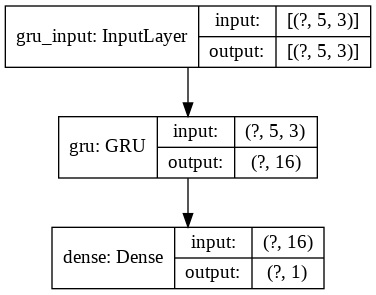

In [ ]:
keras.utils.plot_model(model_rnn_unique_1, show_shapes=True)

RMSE:  105.29059900805733


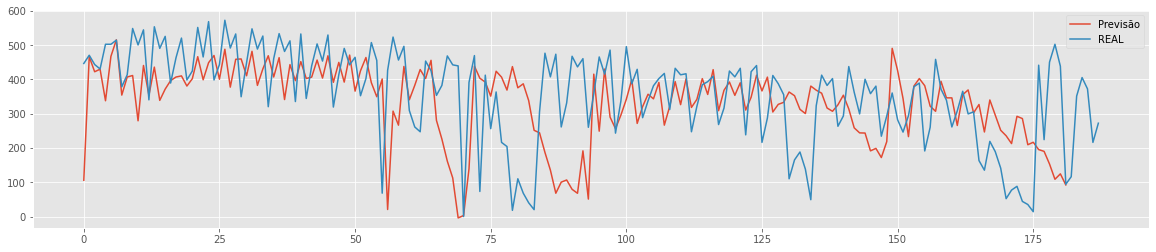

In [ ]:

x_test = scaled_test_x
pred_y = model_rnn_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


CORRELAÇÃO (r): 0.6242807531784139 Pi (p) :4.697523960835619e-21
RMSE = 105.29059900805733
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 60287.544227838516
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5850.3830716609955
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7484.927299499512
ERRO ABSOLUTO MÉDIO = 73.27093610527751
ERRO ABSOLUTO PERCENTUAL MÉDIO = 127.75553802351286%


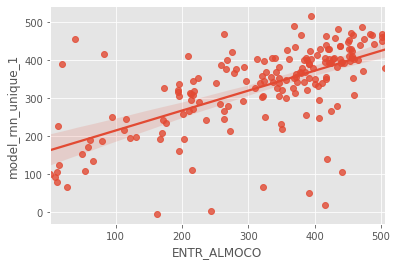

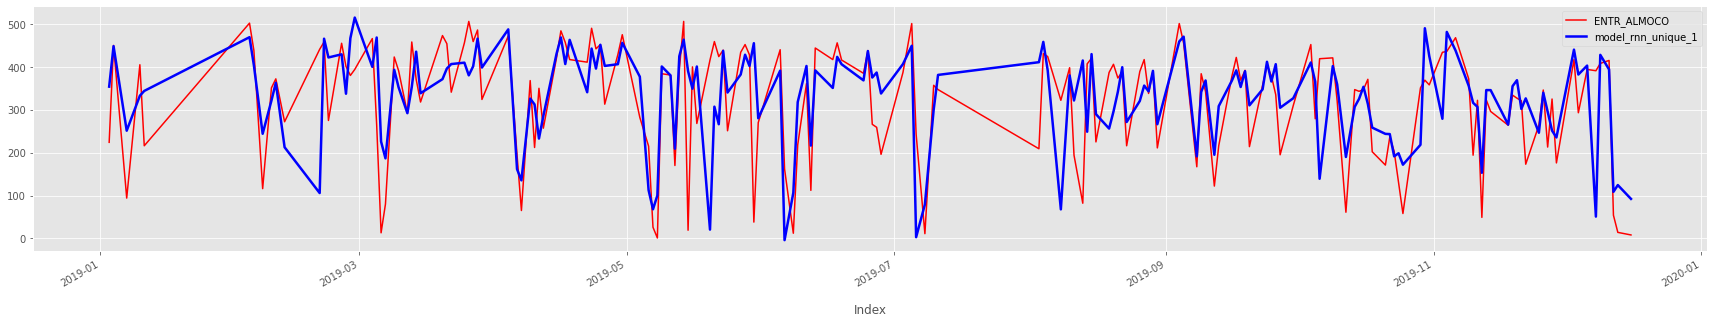

(0.6242807531784139,
 4.697523960835619e-21,
 105.29059900805733,
 127.75553802351286,
 -5850.3830716609955,
 7484.927299499512)

In [ ]:
import scipy
import seaborn as sns
df_test['model_rnn_unique_1'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_rnn_unique_1',df_models_metrics)

#### **model_rnn_unique_2**

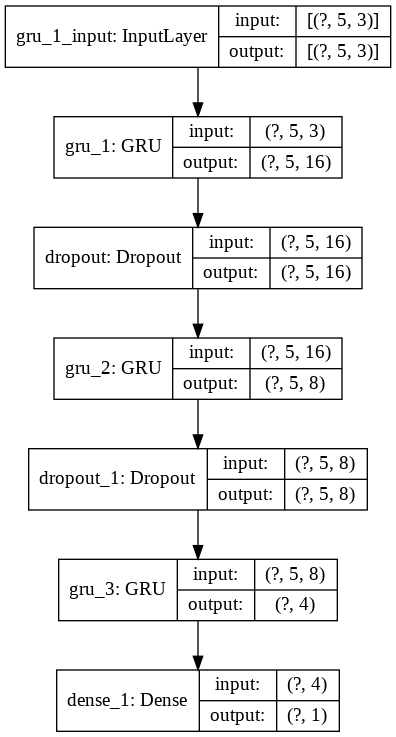

In [ ]:
keras.utils.plot_model(model_rnn_unique_2, show_shapes=True)

RMSE:  107.52495424813935


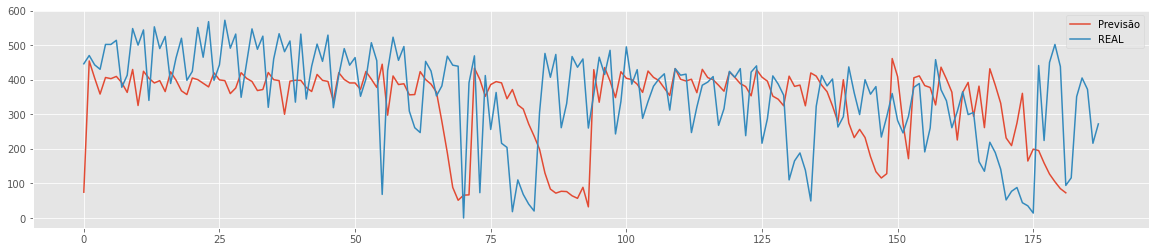

In [ ]:
x_test = scaled_test_x
pred_y = model_rnn_unique_2.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CORRELAÇÃO (r): 0.6083895347940595 Pi (p) :8.272665434732146e-20
RMSE = 107.52495424813935
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 60626.45716094971
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6034.658485412598
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 8008.115646362305
ERRO ABSOLUTO MÉDIO = 77.15809962513683
ERRO ABSOLUTO PERCENTUAL MÉDIO = 111.69923982632352%


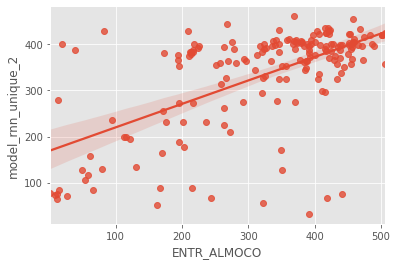

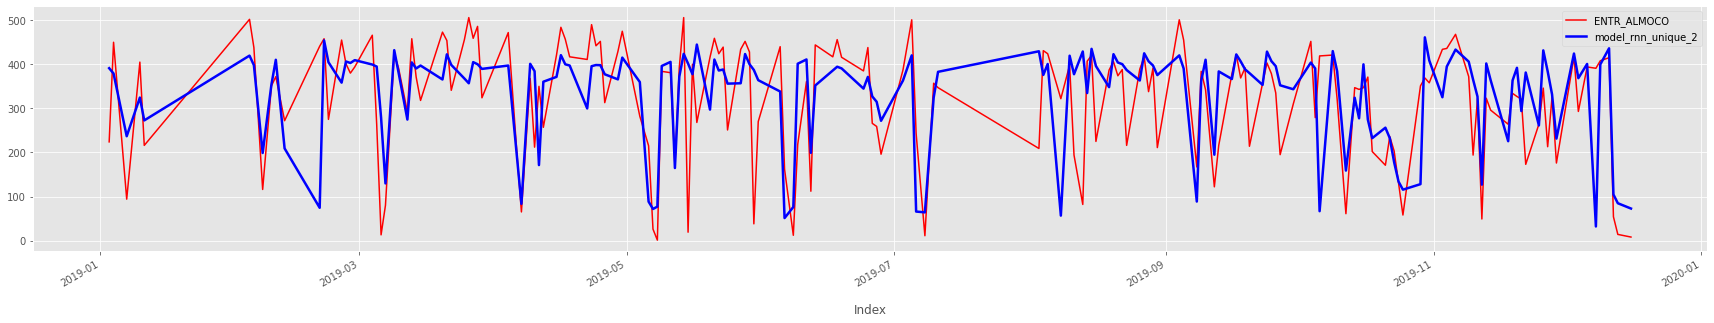

(0.6083895347940595,
 8.272665434732146e-20,
 107.52495424813935,
 111.69923982632352,
 -6034.658485412598,
 8008.115646362305)

In [ ]:
df_test['model_rnn_unique_2'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_rnn_unique_2',df_models_metrics)

#### **model_mlp_unique_1**

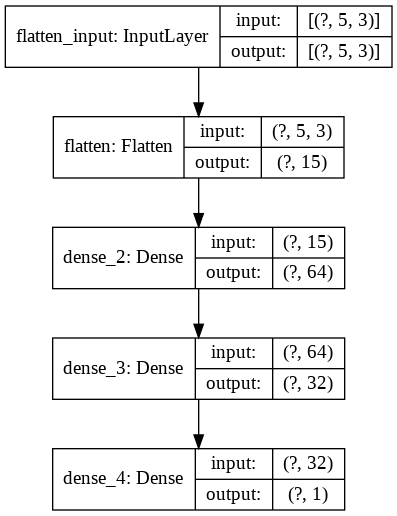

In [ ]:
keras.utils.plot_model(model_mlp_unique_1, show_shapes=True)

RMSE:  113.44053966146716


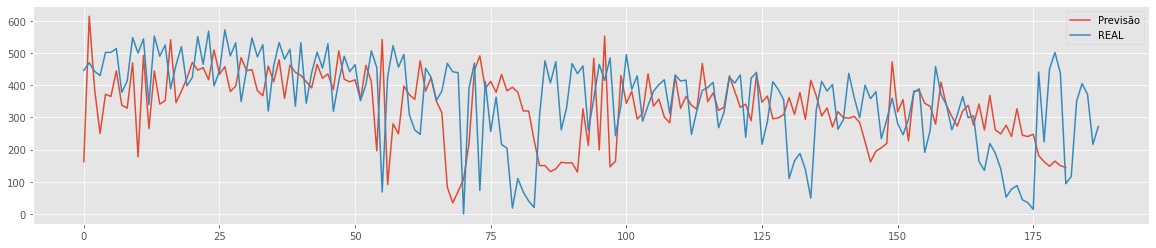

In [ ]:
x_test = scaled_test_x
pred_y = model_mlp_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CORRELAÇÃO (r): 0.5606496658977157 Pi (p) :1.8639063865834323e-16
RMSE = 113.44053966146716
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 60724.67622375488
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6502.241348266602
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 8573.917572021484
ERRO ABSOLUTO MÉDIO = 82.83603802356092
ERRO ABSOLUTO PERCENTUAL MÉDIO = 180.1723854008657%


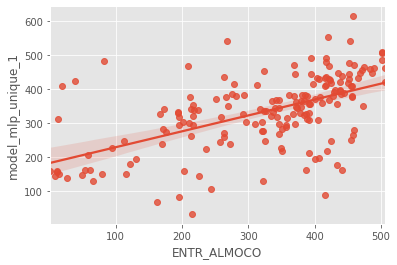

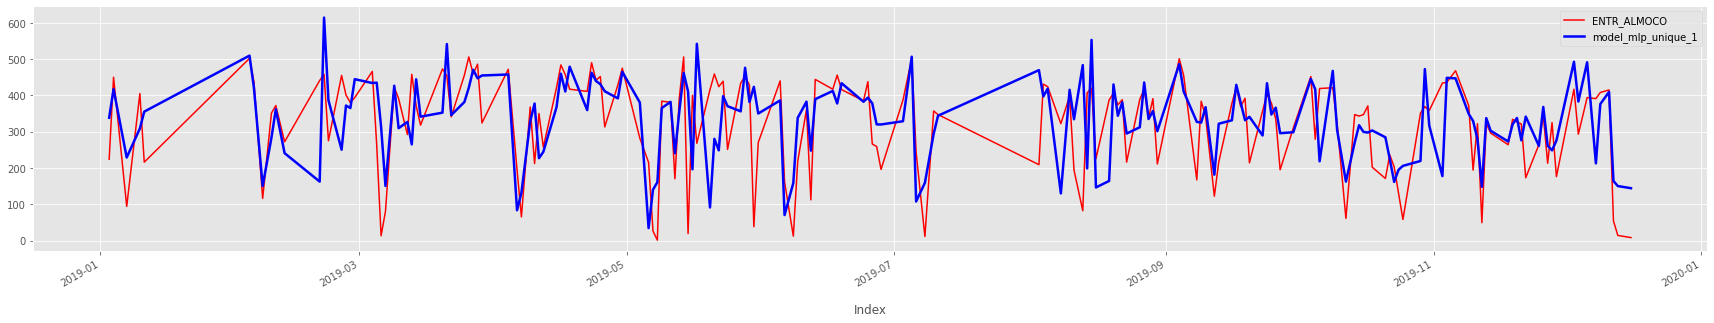

(0.5606496658977157,
 1.8639063865834323e-16,
 113.44053966146716,
 180.1723854008657,
 -6502.241348266602,
 8573.917572021484)

In [ ]:
df_test['model_mlp_unique_1'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_mlp_unique_1',df_models_metrics)

#### **MULTI INPUT MODELS**
multiinput_model_1
multiinput_model_2
multiinput_model_3

#### **multiinput_model_1**

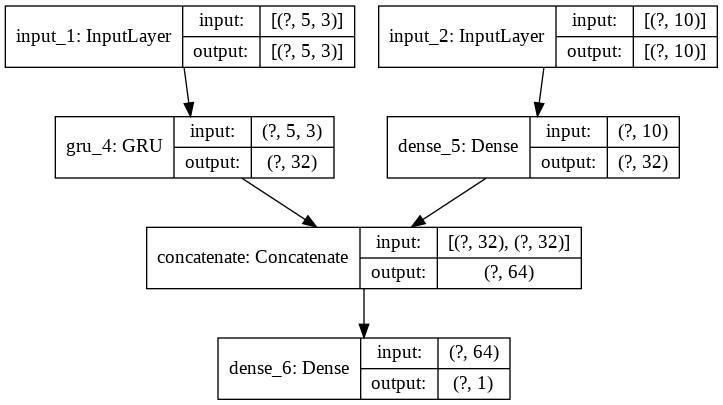

In [ ]:
keras.utils.plot_model(multiinput_model_1, show_shapes=True)

RMSE:  100.63156037359005


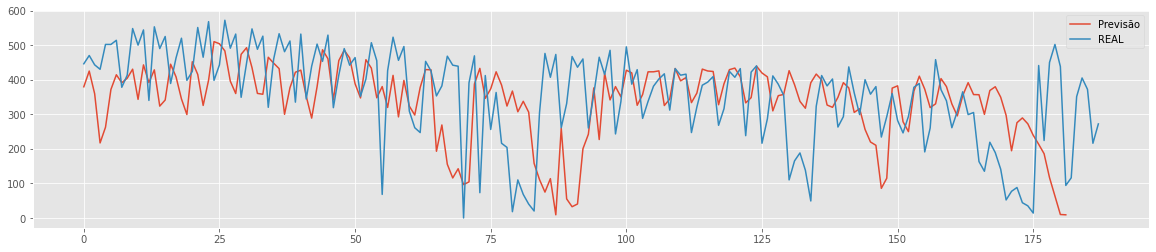

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.6620507408121243 Pi (p) :2.5375976734588204e-24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 100.63156037359005
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 61149.01122760773
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5214.335341453552
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7710.346569061279
ERRO ABSOLUTO MÉDIO = 71.01473577205951
ERRO ABSOLUTO PERCENTUAL MÉDIO = 199.80317309774017%


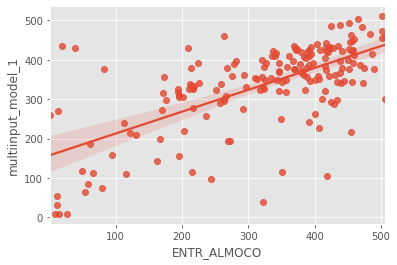

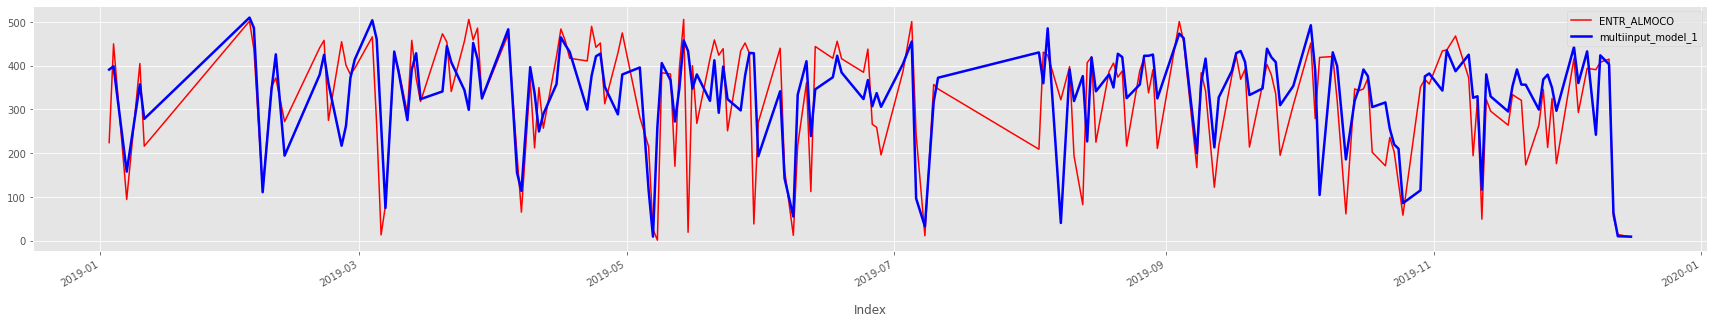

(0.6620507408121243,
 2.5375976734588204e-24,
 100.63156037359005,
 199.80317309774017,
 -5214.335341453552,
 7710.346569061279)

In [ ]:
df_test['multiinput_model_1'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_1',df_models_metrics)

#### **multiinput_model2**

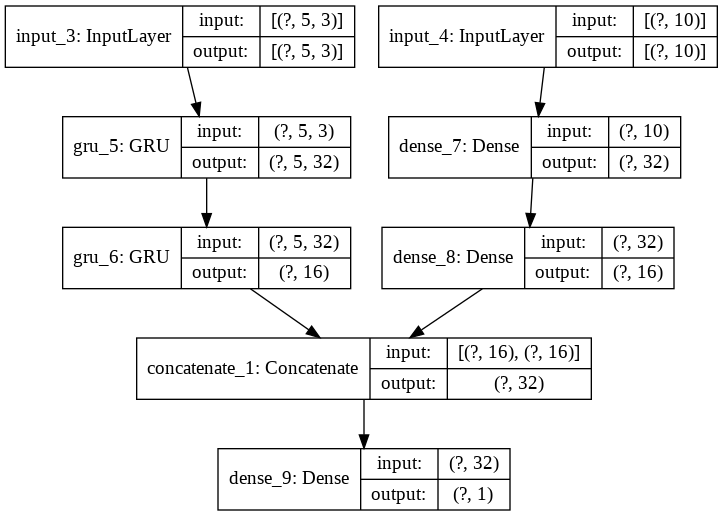

In [ ]:
keras.utils.plot_model(multiinput_model_2, show_shapes=True)

RMSE:  338.98297580944757


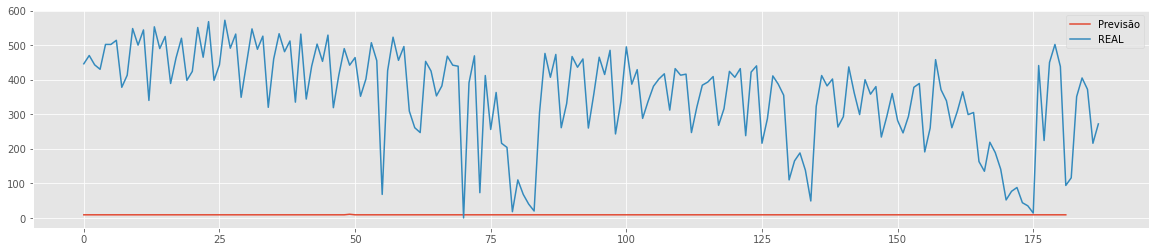

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_2.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)

# 
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.0761623758768516 Pi (p) :0.3068318214736848


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 338.98297580944757
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 1639.601152420044
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -57022.398847579956
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 9.0
ERRO ABSOLUTO MÉDIO = 313.3593343273624
ERRO ABSOLUTO PERCENTUAL MÉDIO = 97.98693846111121%


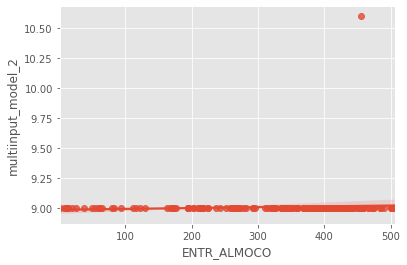

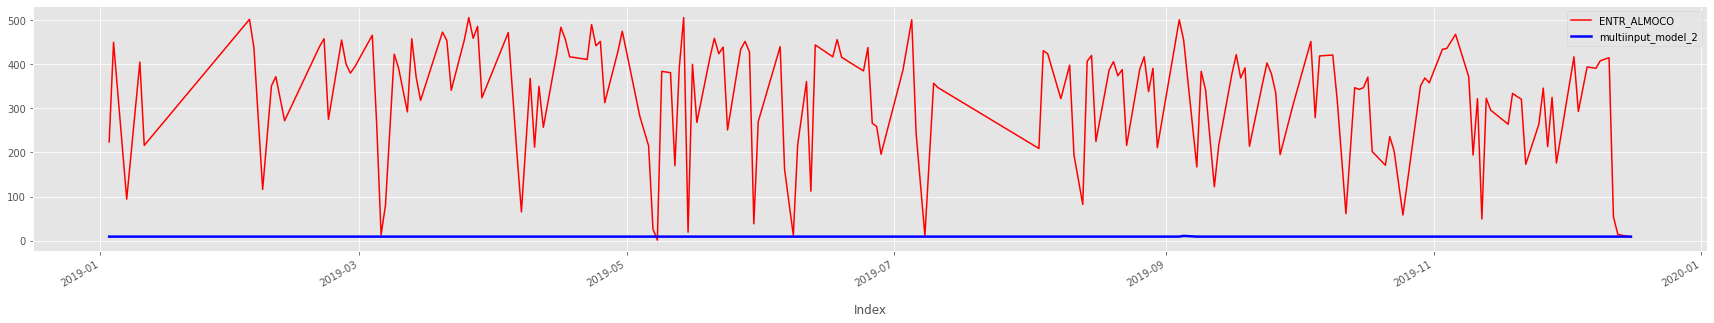

(0.0761623758768516,
 0.3068318214736848,
 338.98297580944757,
 97.98693846111121,
 -57022.398847579956,
 9.0)

In [ ]:
df_test['multiinput_model_2'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_2',df_models_metrics)

#### **multiinput_model_3**

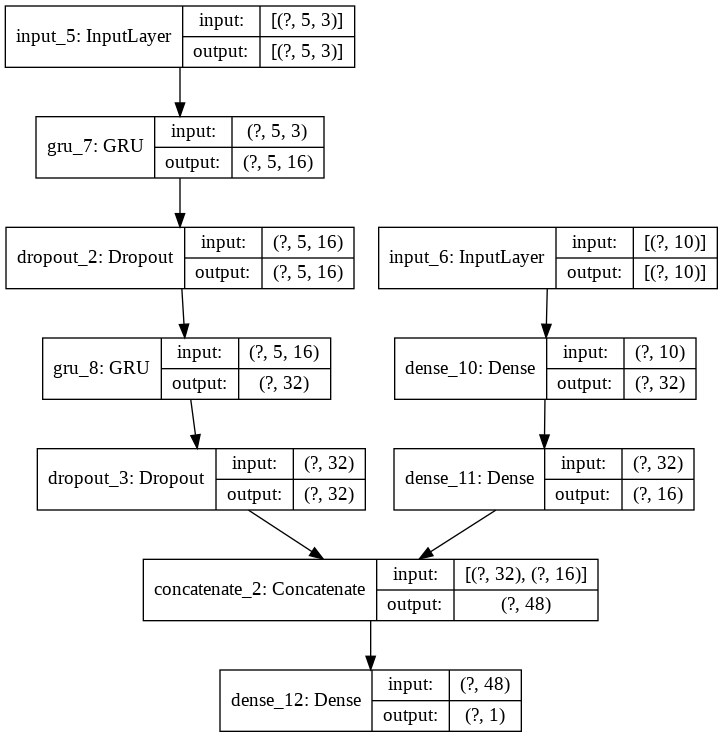

In [ ]:
keras.utils.plot_model(multiinput_model_3, show_shapes=True)

RMSE:  108.96674074789901


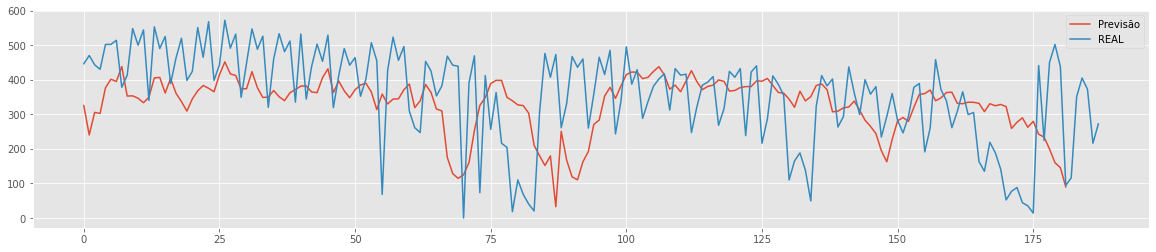

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_3.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.5472910014335856 Pi (p) :1.3039777054183767e-15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 108.96674074789901
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 60002.51856613159
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -7186.829116821289
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 8536.34768295288
ERRO ABSOLUTO MÉDIO = 86.3910813174405
ERRO ABSOLUTO PERCENTUAL MÉDIO = 221.23328745764974%


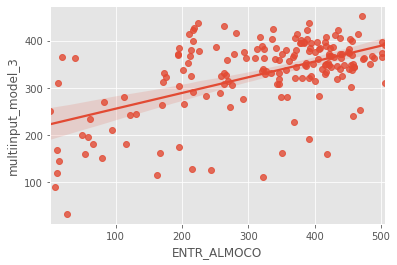

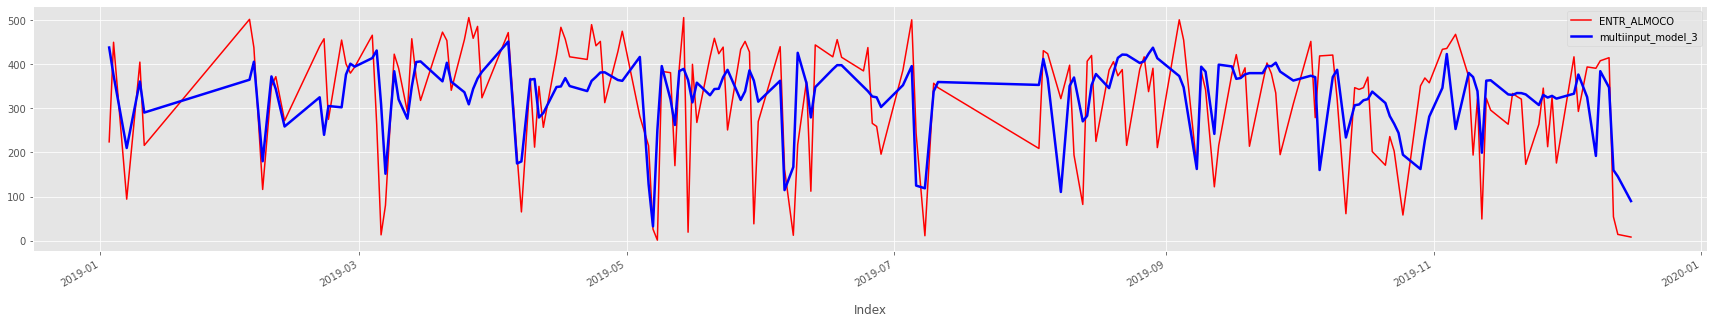

(0.5472910014335856,
 1.3039777054183767e-15,
 108.96674074789901,
 221.23328745764974,
 -7186.829116821289,
 8536.34768295288)

In [ ]:
df_test['multiinput_model_3'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_3',df_models_metrics)

RMSE:  105.29059900805733


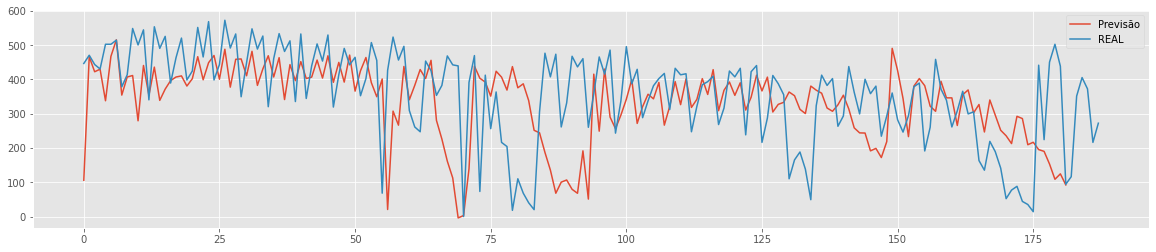

In [ ]:
#model_rnn_unique_1
x_test = scaled_test_x
pred_rnn_unique_1_new_final = model_rnn_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_rnn_unique_1_new_final = scalers[feature_to_predict].inverse_transform(pred_rnn_unique_1_new_final)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(test_y, pred_rnn_unique_1_new_final)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_rnn_unique_1_new_final, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CORRELAÇÃO (r): 0.6242807531784139 Pi (p) :4.697523960835619e-21
RMSE = 105.29059900805733
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 60287.544227838516
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5850.3830716609955
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7484.927299499512
ERRO ABSOLUTO MÉDIO = 73.27093610527751
ERRO ABSOLUTO PERCENTUAL MÉDIO = 127.75553802351286%


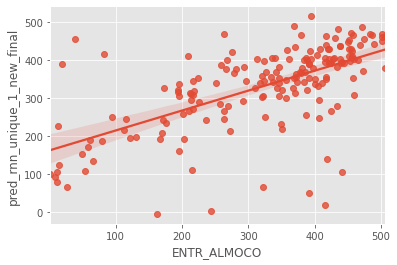

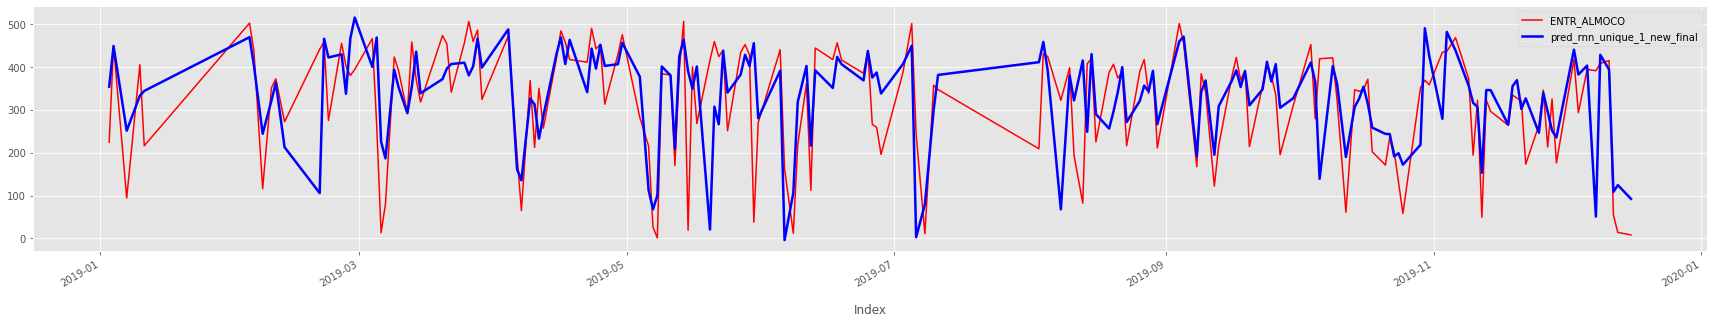

(0.6242807531784139,
 4.697523960835619e-21,
 105.29059900805733,
 127.75553802351286,
 -5850.3830716609955,
 7484.927299499512)

In [ ]:
df_test['pred_rnn_unique_1_new_final'] = pred_rnn_unique_1_new_final
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'pred_rnn_unique_1_new_final',df_models_metrics)

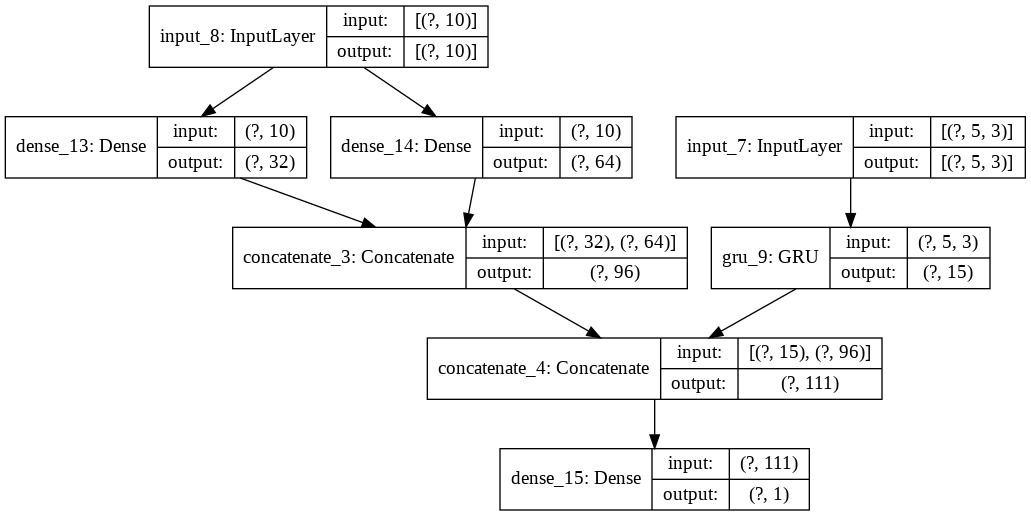

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(15, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense1 = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense2 = layers.Dense(64, activation='relu')(input_layer_dense)
layer_dense = layers.concatenate([layer_dense1, layer_dense2])
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru , layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_1_new = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################

multiinput_model_1_new.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_1_new, show_shapes=True)

RMSE:  270.320291390856


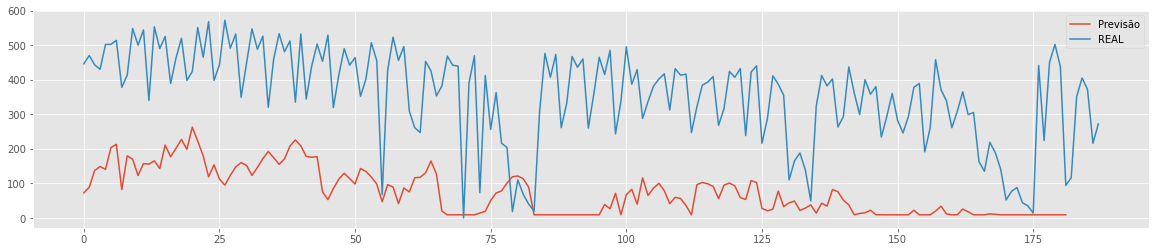

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_1_new.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CORRELAÇÃO (r): 0.5384940154942419 Pi (p) :4.481698958218249e-15
RMSE = 270.320291390856
TOTAL DE REFEIÇÕES PROJETADAS = 182 : 13651.08142375946
TOTAL DE REFEIÇÕES CONSUMIDAS = 182 : 58653
TOTAL DE REFEIÇÕES SUB PROJETADAS = -45243.82209300995
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 241.90351676940918
ERRO ABSOLUTO MÉDIO = 249.92156928450197
ERRO ABSOLUTO PERCENTUAL MÉDIO = 85.18089404603563%


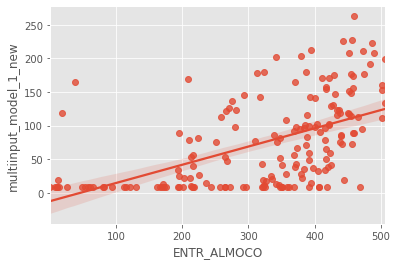

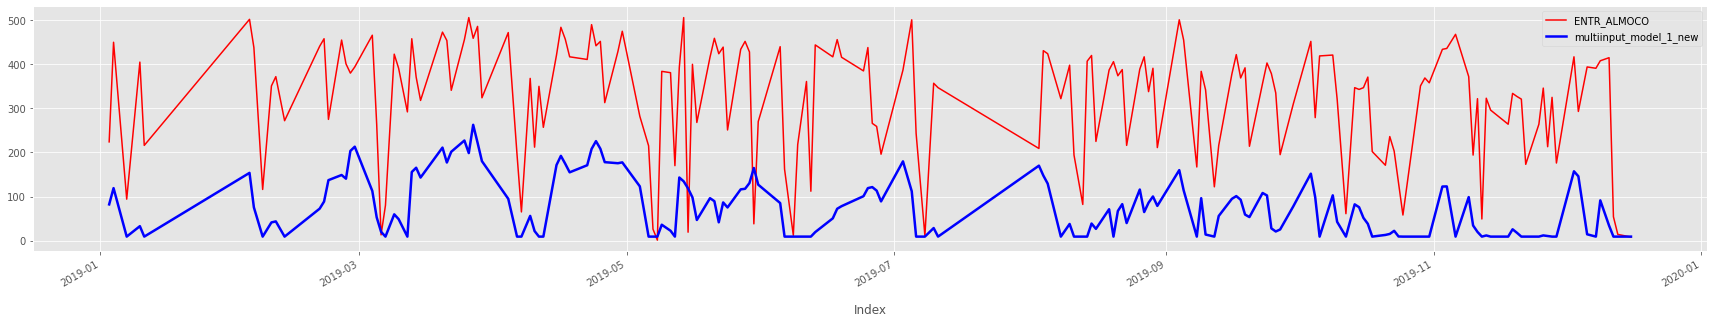

(0.5384940154942419,
 4.481698958218249e-15,
 270.320291390856,
 85.18089404603563,
 -45243.82209300995,
 241.90351676940918)

In [ ]:
df_test['multiinput_model_1_new'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_1_new',df_models_metrics)

In [ ]:
df_models_metrics

,parameters,model_rnn_unique_1,model_rnn_unique_2,model_mlp_unique_1,multiinput_model_1,multiinput_model_2,multiinput_model_3,pred_rnn_unique_1_new_final,multiinput_model_1_new
0,TOTAL_PROJETADAS,60287.544228,60626.457161,60724.676224,61149.011228,1639.601152,60002.518566,60287.544228,13651.081424
1,TOTAL_CONSUMIDAS,58653.000000,58653.000000,58653.000000,58653.000000,58653.000000,58653.000000,58653.000000,58653.000000
2,TOTAL_SUBPROJETADAS,-5850.383072,-6034.658485,-6502.241348,-5214.335341,-57022.398848,-7186.829117,-5850.383072,-45243.822093
3,TOTAL_SUPERPROJETADAS,7484.927299,8008.115646,8573.917572,7710.346569,9.000000,8536.347683,7484.927299,241.903517
4,ERRO_ABS_MEDIO,73.270936,77.158100,82.836038,71.014736,313.359334,86.391081,73.270936,249.921569
5,ERRO_ABS_PER_MEDIO,127.755538,111.699240,180.172385,199.803173,97.986938,221.233287,127.755538,85.180894
